In [1]:
import jax
import jaxlib
import jax.numpy as np
import numpy as onp
import cantera as ct
from scipy.integrate import solve_ivp
from functools import partial
from jax.config import config
config.update("jax_enable_x64", True)
print(f"Using jax: {jax.__version__}")
print(f"Using jaxlib: {jaxlib.__version__}")
print(f"Using cantera: {ct.__version__}")

Using jax: 0.1.64
Using jaxlib: 0.1.45
Using cantera: 2.5.0a3


In [2]:
#jax reactor
from jax_reactor import kinetics, thermo, solution, dataclass

# Use Cantera to set up simulation

In [3]:
gas = ct.Solution('gri30.yaml')

In [4]:
#Global parameters 
T = 1001.
P = ct.one_atm
R = ct.gas_constant
X = 'H2:2,O2:1,N2:4'

In [5]:
gas.TPX = T, P, X

# Get  initial mole fractions (Y) and gas_info as namedtuple

In [6]:
Y, gas_info = solution.get_initial_mole_fractions_and_state('gri30.yaml',T, P, X)

# Get NASA polynomials, kinetics parameters from YAML 

In [7]:
yaml_file = '/home/sirumalla.s/Code/cantera/data/gri30.yaml'
mechanism_dict = dataclass.load_yaml(yaml_file)
nasa_poly = dataclass.get_nasa_polynomials_from_yaml(mechanism_dict)
kinetics_coeffs, kinetics_data =  dataclass.get_kinetic_parameters_from_yaml(mechanism_dict, gas)

# Get dYdt 

In [8]:
#use partial to hoist all parameters so we get a function of type f(t,y) for solve_ivp
get_dYdt_with_options=partial(solution.get_dYdt, P, R, gas_info, nasa_poly, kinetics_coeffs, kinetics_data)

In [9]:
#JIT the function
jitted_get_dYdt_with_options = jax.jit(get_dYdt_with_options)

In [10]:
def get_dYdt_onp(t, state_vec):
    dYdt = jitted_get_dYdt_with_options(t,state_vec)
    return onp.asarray(dYdt,dtype=onp.float64)

# Get Jacobian using forward mode automatic differentiation

In [11]:
jac_fwd = jax.jacfwd(get_dYdt_with_options,(1,)) # fwd mode jacobian w.r.t to 2nd arguement(state_vec)
jit_jac_fwd = jax.jit(jac_fwd)

In [12]:
def get_jac_onp(t, state_vec):
    jac = jit_jac_fwd(t,state_vec)
    return onp.asarray(jac[0],dtype=onp.float64)

# Initial Conditions

In [13]:
Y0 = np.hstack((T, Y))

# Integrate and save results 

In [14]:
t = 0
t_end = 1e-3
states_jax = ct.SolutionArray(gas, 1, extra={'t': [0.0]})
dt = 1e-5
ode_success = True
y = Y0
while ode_success and t < t_end:
    odesol = solve_ivp(get_dYdt_onp,
                       t_span=(t, t + dt),
                       y0=y,
                       method='BDF',
                       jac=get_jac_onp)
    t = odesol.t[-1]
    y = np.array(odesol.y[:, -1],dtype=np.float64)
    ode_success = odesol.success
    gas.TPY = odesol.y[0, -1], P , odesol.y[1:, -1]
    states_jax.append(gas.state, t=t)

# Now solve it using Cantera

In [15]:
ct_gas = ct.Solution('gri30.yaml')
ct_gas.TPX = T, P, X

## Adapted from Cantera's official examples
https://cantera.org/examples/python/reactors/custom.py.html

In [16]:
class ReactorOde(object):
    def __init__(self, gas):
        # Parameters of the ODE system and auxiliary data are stored in the
        # ReactorOde object.
        self.gas = gas
        self.P = gas.P

    def __call__(self, t, y):
        """the ODE function, y' = f(t,y) """

        # State vector is [T, Y_1, Y_2, ... Y_K]
        self.gas.set_unnormalized_mass_fractions(y[1:])
        self.gas.TP = y[0], self.P
        rho = self.gas.density
        #print(f'rho \t {rho}')
        wdot = self.gas.net_production_rates
        #print(f'wdot \t {wdot}')
        dTdt = - (onp.dot(self.gas.partial_molar_enthalpies, wdot) /
                  (rho * self.gas.cp))
        #print(f'partial molar enthalpies \t {partial_molar_enthalpies}')
        dYdt = wdot * self.gas.molecular_weights / rho

        return onp.hstack((dTdt, dYdt))

In [17]:
ct_ode = ReactorOde(ct_gas)

In [18]:
y0 = onp.hstack((ct_gas.T,ct_gas.Y))

In [19]:
t_end = 1e-3
states = ct.SolutionArray(ct_gas, 1, extra={'t': [0.0]})
dt = 1e-5
t = 0
ode_success = True
y = y0
while ode_success and t < t_end:
    odesol = solve_ivp(ct_ode,
                       t_span=(t, t + dt),
                       y0=y,
                       method='BDF',
                       vectorized=False, jac=None)

    t = odesol.t[-1]
    y = odesol.y[:, -1]
    ode_success = odesol.success
    ct_gas.TPY = odesol.y[0, -1], ct.one_atm, odesol.y[1:, -1]
    states.append(ct_gas.state, t=t)

# Now compare results

In [20]:
import matplotlib.pyplot as plt

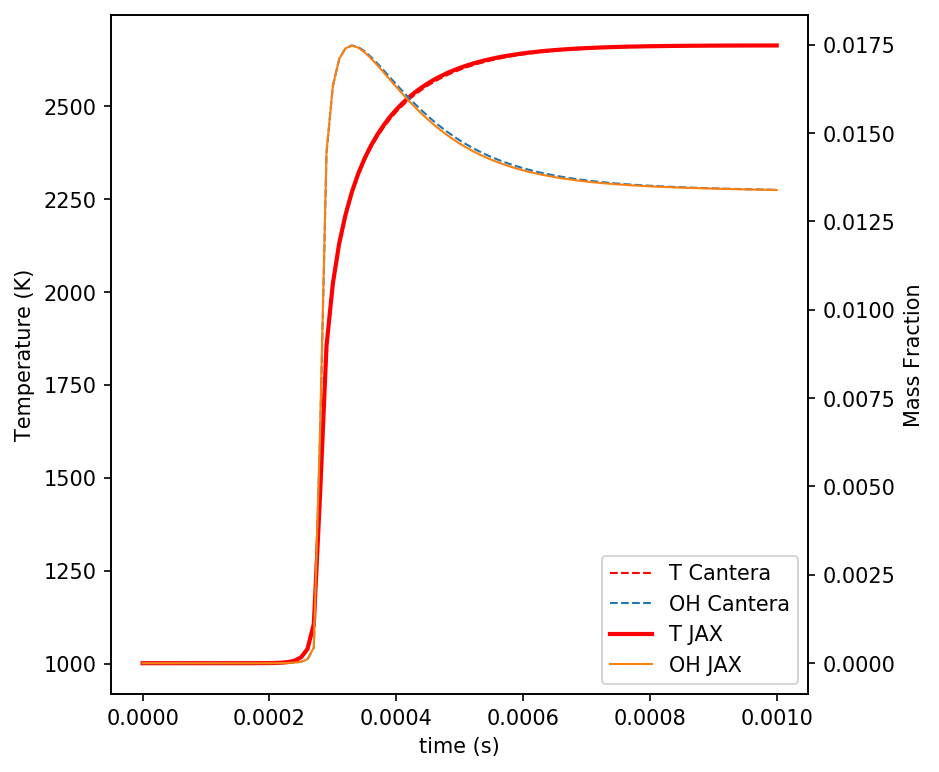

In [21]:
fig = plt.figure(figsize=(6,6),dpi=150)
L1 = plt.plot(states.t, states.T, ls='--', color='r', label='T Cantera', lw=1)
L1_rt = plt.plot(states_jax.t, states_jax.T, ls='-',
                 color='r', label='T JAX', lw=2)
plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')

plt.twinx()
L2 = plt.plot(states.t, states('OH').Y, ls='--', label='OH Cantera', lw=1)
L2_rt = plt.plot(states_jax.t, states_jax(
    'OH').Y, ls='-', label='OH JAX', lw=1)
plt.ylabel('Mass Fraction')

plt.legend(L1+L2+L1_rt+L2_rt, [line.get_label()
                               for line in L1+L2+L1_rt+L2_rt], loc='lower right')
plt.show()